#14757 Homework 3 (150 pts)

## **Due:** Wednesday October 23 at 3pm ET / 12 noon PT

## Submission Instructions

*   Download your completed notebook by clicking File->Download .ipynb and submit it on Gradescope
*   Check your submission on Gradescope to make sure that all your code, code output and written responses appear correctly

## Tips for getting started

*   Make sure to set your Colab runtime type to GPU hardware acceleration.

*   You will require knowledge of PyTorch to complete this assignment. We recommend that you read all four sections of the following tutorial. The starter code for Problem 2 is adapted from the last section.

  https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

*   As you work on this assignment you will likely need to refer to the PyTorch documentation.

  https://pytorch.org/docs/stable/index.html

## Problem 1: Gradescope Autograder Placeholder (0 pts)

Gradescope requires that problem 1 be autograded for code submissions, but there are no autograded problems. Continue to problem 2.

In this problem you will tweak an existing convolutional neural network image classifier that runs on the CIFAR-10 data set.

The starter code is adapted from the tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

First run the cell below to observe the following steps.

* Load and normalize the CIFAR-10 training and test datasets using ``torchvision``
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data

Now tweak the code in the cell below as follows.

* (20 pts) Train the model on a GPU
* (20 pts) Add one more convolutional layer to the model
* (20 pts) Apply dropout to the input layer
* (10 pts) Increase the batch size for training
* (10 pts) Increase the number of training epochs
* (10 pts) Change the optimization algorithm for training

We will not grade you on the accuracy of your classifier, just on the tweaks themselves.

## Problem 2: Tweaking a Convolutional Neural Network (90 pts)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Num workers 2 doesn't work with CUDA on CoLab so multiprocessing used
# import torch.multiprocessing as mp
# mp.set_start_method('spawn', force=True)


# Load and normalize the CIFAR10 training and test datasets
## ORIGINAL = 55%


# MOVING TO GPU IF AVAILABLE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.set_default_device(device)
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# INCREASE THE BATCH SIZE FOR TRAINING
'''
Batch Size seems to have had the largest effect on accuracy compared to all
other methods implemented (3rd CONV layer, Dropout, Epochs)
SGD ONLY
4: 55%
8: 53%
16: 49%
20: 48%
32: 45%

ADAM and 64 feature maps with 3x3 kernel with padding
5 Epochs:
20: 64%
50: 65%
100: 65%

10 Epochs:
50: 66%
100: 67%
200: 66%
'''
# batch_size = 4 ## ORIGINAL
batch_size = 50 # better divisibility between batchsizes and 10k set if % 10


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define a Convolutional Neural Network

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    '''
    Using 2D Convolution operation to create kernels:
    Formula: Output Size = ((Input Size - Kernel Size + 2 * Padding)/Stride) + 1
     Conv Layer Observations
      Testing:  Applying a smaller kernel value of 3x3 with stride 1 and padding 1
                vastly outperformed the kernel sizes of 5x5 with less feature maps.
      Assumption: Smaller kernel allowed model to retain finer details while the
                  padding and stride allowed it to retain spatial details.
     Linear Layer Observations

    nn.Conv2d(x1,x2,x3)
      x1 = num input channels. 1st layer is usually 3 for RGB or 1 for grayscale
      x2 = num output channles. num kernels that layer will learn resulting in the
           same num of feature maps, 1 for each filter.
      x3 = size of kernels. single int mens x3 x x3 like 5x5 or 3x3, or tuple
           with height and width

      - The next layer's input = the previous layer's output channel/feature maps
      - Layer 3 reduces the kernel size to capture more details
      - Little to no difference in 3rd Conv layer output from 32 to 64 with first
            going from 3, 6 so tried upping the feature map and lowering the kernel size
    ReLU:
      Introduces non-linearity so that model can capture complex features from
      nonlinear patters. Needed after every linear layer performs matmul and adding
      bias. ReLU takes only the positive values after that and zeros where other
      things would have been negative with max(0,x) activation function. This
      basically introduces sparsity which reduces overfitting and improves efficiency.
      However there are limits
        Observation: 3rd ReLU actually brought accuracy down 1% meaning there's a limit
                    to the benefits. This even happened after evening out the reduction
                    between in linear transformations.
        Assumption: 3rd ReLU could be overfitting or the limits of the linear transform
                    were reached quickly after the 3rd Conv layer
    Pooling:
      Form of dimensionality reduction that reduces the spatial dimensions of
      the feature maps (width, height). Helps prevent overfitting and detection
      of features more robust by highlighting the most prominent features in maps

      This net reduces width and height by half using a 2x2 kernel with a stride of 2
      So 28x28 gets reduced to 14x14 and so on.
    Dropout:
      Simple technique to randomly drop a % of neurons so that they're ignored
      on a forward pass and weight updates are not applied on backprop.

      Forces network to learn more robust features on each pass and averages those
      to effectively make an averaged model of neurons.

    '''
    self.dropout = nn.Dropout(p=0.3) # APPLY DROPOUT TO INPUT LAYER
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)  # ADDING NEW CONV LAYER
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 4 * 4, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 10)


  def forward(self, x):
    '''
    Big source of errors: make sure that the last layer does not pool
    In this case, conv3 otherwise, very hard to make this size of 32 feature map
    map correctly to the flattened feature map from conv3 given the 2x2 kernel
    and 2 stride coming down from a 3x3 kernel
    '''
    x = self.dropout(x)  # APPLY DROPOUT TO INPUT LAYER
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x))) # FORWARD PASS FOR NEW CONV LAYER,
    # x = x.view(-1, 64 * 4 * 4)
    x = torch.flatten(x, 1) # same effect, but much better coding because done dynamically
    x = F.relu(self.fc1(x))
    # x = F.relu(self.fc2(x))
    x = self.fc2(x)
    return x

# MOVING TO GPU IF AVAILABLE
net = Net().to(device)

# Define a loss function

criterion = nn.CrossEntropyLoss()

# CHANGE OPTIMIZATION ALGORITHM: from SGD to ADAM to ADAGRAD
# SGD:     48%
# ADAM:    54% | Makes sense since it combines SGD-Momentum and RMSprop
#          64% | Using smaller kernel, padding, and more features with 2x RELU
# ADAGRAD: 34%
# RMSprop: 51%
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the network on the training data

print('Starting Training')

# INCREASE NUMBER OF EPOCHS
for epoch in range(10):  # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device) # MOVING TO GPU IF AVAILABLE

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training', end='\n\n')

# Test the network on the test data

correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)  # MOVING TO GPU IF AVAILABLE
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

cuda:0
Files already downloaded and verified
Files already downloaded and verified
Starting Training
[1,   200] loss: 0.208
[1,   400] loss: 0.164
[1,   600] loss: 0.149
[1,   800] loss: 0.139
[1,  1000] loss: 0.133
[2,   200] loss: 0.126
[2,   400] loss: 0.122
[2,   600] loss: 0.119
[2,   800] loss: 0.116
[2,  1000] loss: 0.115
[3,   200] loss: 0.106
[3,   400] loss: 0.105
[3,   600] loss: 0.104
[3,   800] loss: 0.104
[3,  1000] loss: 0.102
[4,   200] loss: 0.096
[4,   400] loss: 0.095
[4,   600] loss: 0.094
[4,   800] loss: 0.095
[4,  1000] loss: 0.094
[5,   200] loss: 0.087
[5,   400] loss: 0.089
[5,   600] loss: 0.085
[5,   800] loss: 0.087
[5,  1000] loss: 0.088
[6,   200] loss: 0.079
[6,   400] loss: 0.081
[6,   600] loss: 0.081
[6,   800] loss: 0.082
[6,  1000] loss: 0.080
[7,   200] loss: 0.074
[7,   400] loss: 0.074
[7,   600] loss: 0.076
[7,   800] loss: 0.078
[7,  1000] loss: 0.075
[8,   200] loss: 0.066
[8,   400] loss: 0.069
[8,   600] loss: 0.070
[8,   800] loss: 0.073
[8

In this problem you will tweak an existing convolutional neural network image classifier that runs on the CIFAR-10 data set.

The starter code is adapted from the tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

First run the cell below to observe the following steps.

* Load and normalize the CIFAR-10 training and test datasets using ``torchvision``
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data

Now tweak the code in the cell below as follows.

* (20 pts) Train the model on a GPU
* (20 pts) Add one more convolutional layer to the model
* (20 pts) Apply dropout to the input layer
* (10 pts) Increase the batch size for training
* (10 pts) Increase the number of training epochs
* (10 pts) Change the optimization algorithm for training

We will not grade you on the accuracy of your classifier, just on the tweaks themselves.

## Problem 3: Attacking a Neural Network Classifier (60 pts)

In this problem you will implement two evasion attacks against a neural network classifier for the MNIST handwritten digits data set.

The starter code is adapted from the following tutorial that you may find useful to read:

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

Run the cell below to

*   load the MNIST handwritten digit test set
*   define the neural network structure and load pretrained parameters
*   define test and display helper functions



In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=False, download=True,
                 transform=transforms.Compose([transforms.ToTensor(),])),
                 batch_size=1, shuffle=True)

# LeNet Model definition
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
!mkdir ./data/
!wget http://www.andrew.cmu.edu/user/dvaroday/14757/data/hw3/lenet_mnist_model.pth
!mv lenet_mnist_model.pth ./data
pretrained_model = "data/lenet_mnist_model.pth"
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the dropout layers.
model.eval()

# HELPER FUNCTIONS

# Test attack_fn() on test data
def test(attack_fn, model, device, test_loader, epsilon):
  # Accuracy counter
  correct = 0
  adv_examples = []

  # Loop over all examples in test set
  for data, target in test_loader:

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True
    # Call attack function
    perturbed_data = attack_fn(data, target, epsilon)
    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success

    # Get the index of the max log-probability
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
      # Special case for saving 0 epsilon examples
      if (epsilon == 0) and (len(adv_examples) < 5):
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (target.item(), final_pred.item(), adv_ex) )
    else:
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (target.item(), final_pred.item(), adv_ex) )

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  # Return the accuracy and adversarial examples
  return final_acc, adv_examples

# Display adversarial examples
def display_examples(epsilons, examples):
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

CUDA Available:  True
mkdir: cannot create directory ‘./data/’: File exists
--2024-10-23 13:45:14--  http://www.andrew.cmu.edu/user/dvaroday/14757/data/hw3/lenet_mnist_model.pth
Resolving www.andrew.cmu.edu (www.andrew.cmu.edu)... 128.2.42.53
Connecting to www.andrew.cmu.edu (www.andrew.cmu.edu)|128.2.42.53|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.andrew.cmu.edu/user/dvaroday/14757/data/hw3/lenet_mnist_model.pth [following]
--2024-10-23 13:45:15--  https://www.andrew.cmu.edu/user/dvaroday/14757/data/hw3/lenet_mnist_model.pth
Connecting to www.andrew.cmu.edu (www.andrew.cmu.edu)|128.2.42.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88724 (87K)
Saving to: ‘lenet_mnist_model.pth’

lenet_mnist_model.p 100%[===================>]  86.64K   442KB/s    in 0.2s    

2024-10-23 13:45:15 (442 KB/s) - ‘lenet_mnist_model.pth’ saved [88724/88724]



<ipython-input-6-333054370bab>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


### Fast gradient sign method (FGSM) attack

Run the cell below to

*   define `fgsm_attack()` as an implementation of FGSM
*   run the FGSM attack against all images in the test set for several values of `epsilon`
*   collect accuracy statistics and display sample adversarial examples




**3.1** (30 pts) Complete the function `iterative_attack()` to implement the iterative method attack described in the lecture titled *Evasion Attacks on Neural Network Classifiers.* Use the provided values of `num_iterations = 3` and `alpha = epsilon/2`.

Note that you should **not** modify the argument `image` because it is a special object that maintains a field called `grad` necessary for backpropagation. Instead we have initialized a tensor called `delta` that you can use to perturb the image.

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


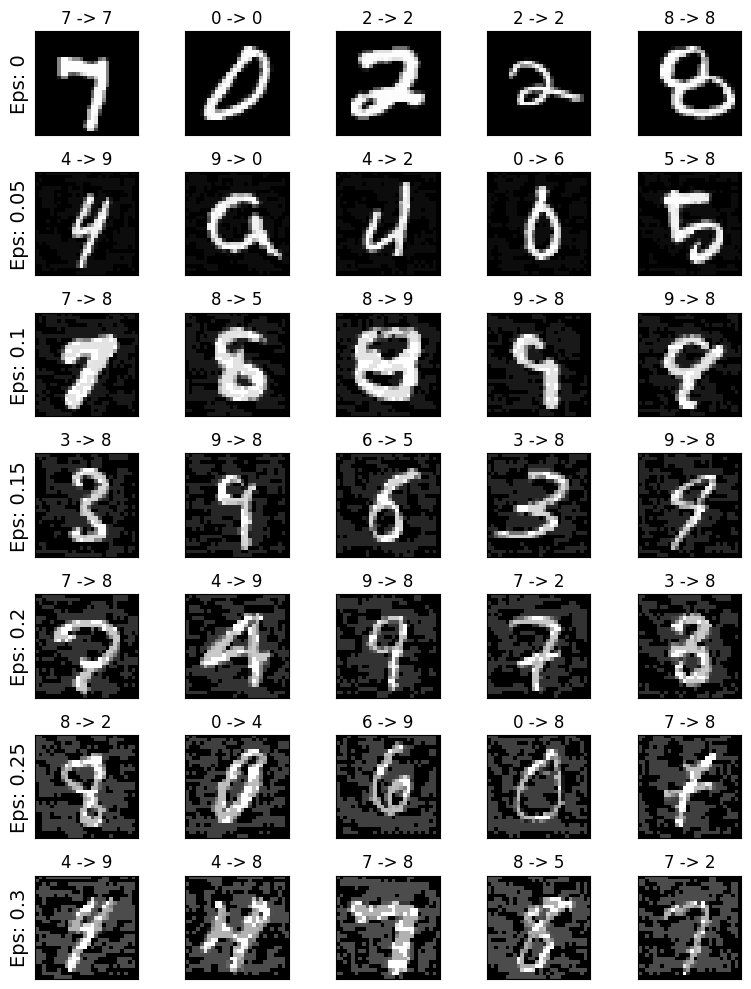

In [7]:
# FGSM attack code
def fgsm_attack(image, target, epsilon):
  # Forward pass the data through the model
  output = model(image)
  # Calculate the loss
  loss = F.nll_loss(output, target)
  # Zero all existing gradients
  model.zero_grad()
  # Calculate gradients of model in backward pass
  loss.backward()
  # Collect the element-wise sign of the data gradient
  sign_data_grad = image.grad.data.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad
  # Clip to maintain [0,1] range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  # Return the perturbed image
  return perturbed_image

# Epsilon values for FGSM attack
# Pixel value range is [0,1] so epsilon < 1
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies_fgsm = []
examples_fgsm = []

# Run test for each epsilon
for eps in epsilons:
  acc, ex = test(fgsm_attack, model, device, test_loader, eps)
  accuracies_fgsm.append(acc)
  examples_fgsm.append(ex)

# Plot several examples of adversarial samples at each epsilon
display_examples(epsilons, examples_fgsm)

### Iterative method attack

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9333 / 10000 = 0.9333
Epsilon: 0.1	Test Accuracy = 8044 / 10000 = 0.8044
Epsilon: 0.15	Test Accuracy = 5477 / 10000 = 0.5477
Epsilon: 0.2	Test Accuracy = 2339 / 10000 = 0.2339
Epsilon: 0.25	Test Accuracy = 610 / 10000 = 0.061
Epsilon: 0.3	Test Accuracy = 110 / 10000 = 0.011


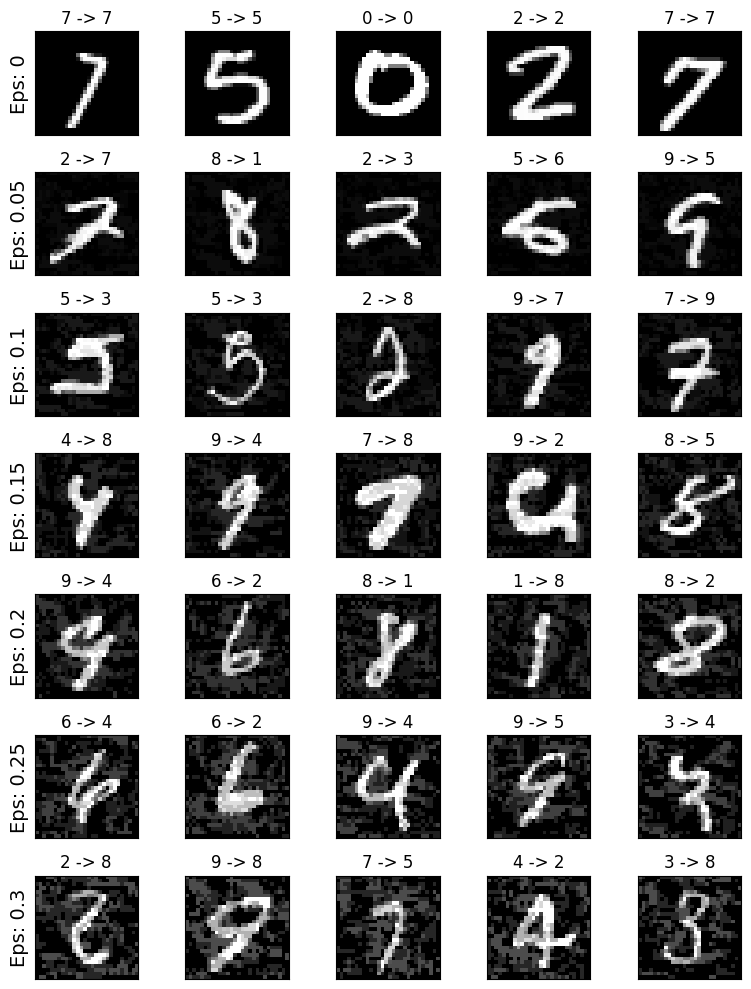

In [14]:
# Iterative method attack code
def iterative_attack(image, target, epsilon):
  num_iterations = 3
  alpha = epsilon/2
  delta = torch.zeros_like(image, requires_grad=True).to(device)

  '''
  The first step here is to use the initial values above and pass it through the
  model, calculate the loss. Then zero_grad followed by backward to calculate
  new gradient. Pretty normal, but for the attack we need the sign of the grad
  to update the epsilon value and combine with the new delta perturbation of
  the image.

  VERY IMPORTANT. Delta will get a NoneType AttributeError unless you require
  a gradient from it which I only found to work as an argument requires_grad = True.
  Additionally, you can only change delta if you access the tensor with delta.data
  as delta is not a leaf tensor
  '''

  # START EDITING HERE - DON'T REMOVE THIS COMMENT
  for i in range(num_iterations):
      # Zero the gradients of delta
      if delta.grad is not None:
          delta.grad.zero_()

      # Forward pass: compute output with perturbed image
      output = model(image + delta)

      # Calculate loss
      loss = F.nll_loss(output, target)

      # Backward pass: compute gradients w.r.t. delta
      loss.backward()

      # Update delta: move in the direction of the gradient sign
      delta.data = delta.data + alpha * delta.grad.data.sign()

      # Clip delta to be within the epsilon ball
      delta.data = torch.clamp(delta.data, -epsilon, epsilon)

  # END EDITING HERE - DON'T REMOVE THIS COMMENT

  # Return the perturbed image
  perturbed_image = torch.clamp(image+delta, 0, 1)
  return perturbed_image

accuracies_iterative = []
examples_iterative = []

# Run test for each epsilon
for eps in epsilons:
  acc, ex = test(iterative_attack, model, device, test_loader, eps)
  accuracies_iterative.append(acc)
  examples_iterative.append(ex)

# Plot several examples of adversarial samples at each epsilon
display_examples(epsilons, examples_iterative)

Run the cell below to compare the accuracies under FGSM and iterative method attacks. You should see that the iterative method degrades accuracy more significantly.

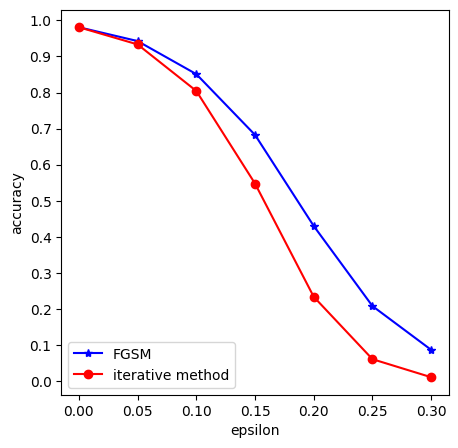

In [15]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_fgsm, 'b*-', label='FGSM')
plt.plot(epsilons, accuracies_iterative, 'ro-', label='iterative method')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.legend(loc='lower left')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.show()

### Targeted iterative method

**3.2** (30 pts) Complete the function `targeted_iterative_attack()` to implement the targeted iterative method attack described in the lecture titled *Evasion Attacks on Neural Network Classifiers.* Your attack should attempt to perturb `image` so that it gets classified as `target_digit = 8`. Continue to use the provided values of `num_iterations = 3` and `alpha = epsilon/2`.

If your implementation is correct you will see convincing evidence among the adversarial images displayed by this cell.

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9628 / 10000 = 0.9628
Epsilon: 0.1	Test Accuracy = 8961 / 10000 = 0.8961
Epsilon: 0.15	Test Accuracy = 7347 / 10000 = 0.7347
Epsilon: 0.2	Test Accuracy = 4738 / 10000 = 0.4738
Epsilon: 0.25	Test Accuracy = 2678 / 10000 = 0.2678
Epsilon: 0.3	Test Accuracy = 1599 / 10000 = 0.1599


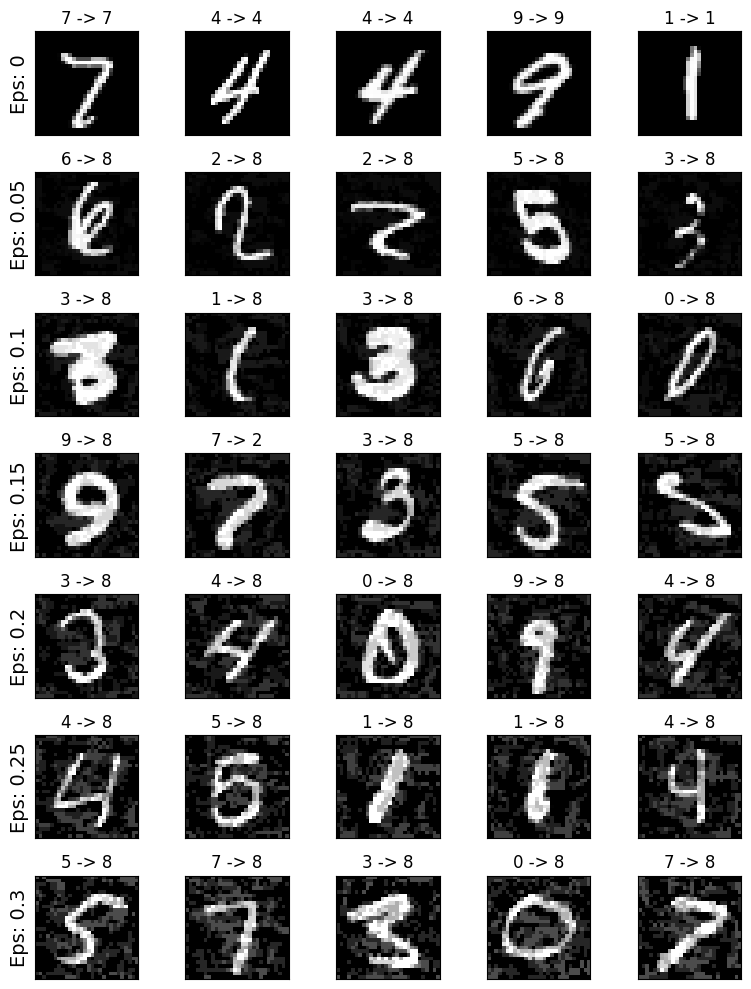

In [16]:
# Targeted iterative method attack code
def targeted_iterative_attack(image, target, epsilon):

  target_digit = 8

  num_iterations = 3
  alpha = epsilon/2
  delta = torch.zeros_like(image, requires_grad=True).to(device)

  '''
  This is not complicated. You do the same thing, but you just change the target

  '''
  # START EDITING HERE - DON'T REMOVE THIS COMMENT
  target_tensor = torch.tensor([target_digit]).to(device)

  for i in range(num_iterations):
      # Zero the gradients of delta
      if delta.grad is not None:
          delta.grad.zero_()

      # Forward pass: compute output with perturbed image
      # Conduct forward pass by passing perturbed image into model
      output = model(image + delta)

      # Calculate the loss w.r.t. the target class (minimize this loss)
      loss = F.nll_loss(output, target_tensor)

      # Backward pass: compute gradients w.r.t. delta
      loss.backward()

      # Update delta: move in the negative direction of the gradient sign
      delta.data = delta.data - alpha * delta.grad.data.sign()

      # Clip delta to ensure perturbations remain within the epsilon ball
      delta.data = torch.clamp(delta.data, -epsilon, epsilon)

  # END EDITING HERE - DON'T REMOVE THIS COMMENT

  # Return the perturbed image
  perturbed_image = torch.clamp(image+delta, 0, 1)
  return perturbed_image

accuracies_targeted = []
examples_targeted = []

# Run test for each epsilon
for eps in epsilons:
  acc, ex = test(targeted_iterative_attack, model, device, test_loader, eps)
  accuracies_targeted.append(acc)
  examples_targeted.append(ex)

# Plot several examples of adversarial samples at each epsilon
display_examples(epsilons, examples_targeted)